In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import RocCurveDisplay
from sklearn.isotonic import IsotonicRegression

from bisect import bisect_left
import pandas as pd
import numpy as np

from skqreg.estimators import GAQuantizedAgg,QuantizationAgg


In [2]:
X, y = fetch_openml(data_id=42900, return_X_y=True, as_frame=False)
X = X[:, [2,7]]
y = np.array(y == np.unique(y)[1], dtype=int)
clf = GAQuantizedAgg().fit(X, y)

/home/sheid/.cache/pypoetry/virtualenvs/scikit-quantistic-regresion-tuRLV2Fq-py3.11/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


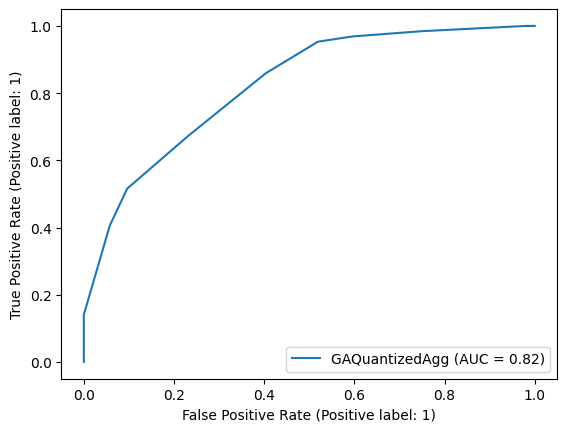

In [3]:
RocCurveDisplay.from_estimator(clf, X, y)

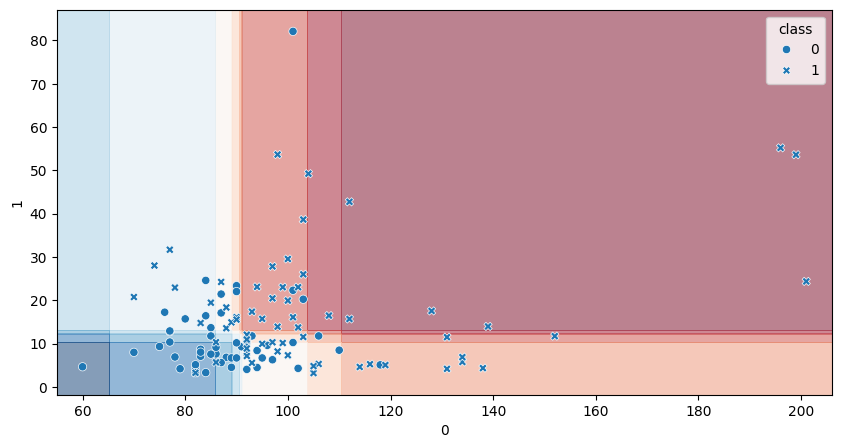

In [4]:
df = pd.DataFrame(X)
df["class"] = y

fig,ax = plt.subplots(figsize=(10, 5))

x1grid = np.linspace(df[0].min()-5, df[0].max()+5, 1000)
x2grid = np.linspace(df[1].min()-5, df[1].max()+5, 1000)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))
# define the model
# make predictions for the grid
yhat = clf.predict_proba(grid)
# keep just the probabilities for class 0
yhat = yhat[:, 0]
# reshape the predictions back into a grid
zz = yhat.reshape(xx.shape)
# plot the grid of x, y and z values as a surface

plt.contourf(xx, yy, zz, cmap='RdBu', levels=np.linspace(0,1,21), alpha=.5)
sns.scatterplot(df,x=0,y=1, style="class", ax=ax)
xlims = ax.get_xlim()
fig.savefig("decision_surface.pdf", bbox_inches ="tight")

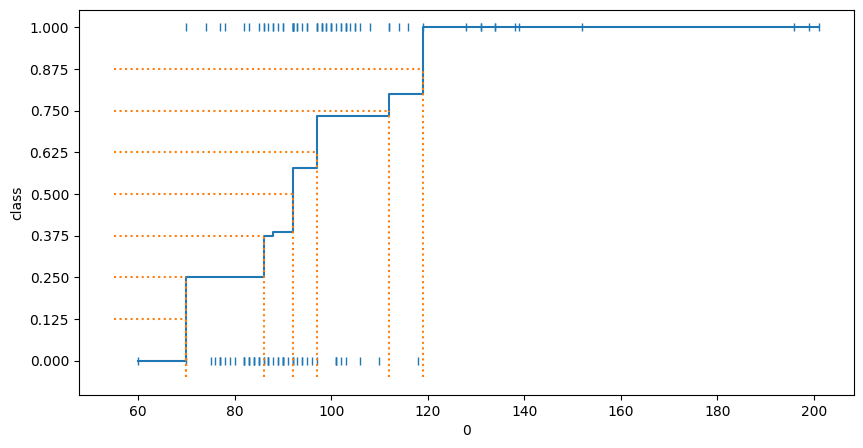

In [8]:
fig,ax = plt.subplots(figsize=(10, 5))
x= X[:, 0]
iso = IsotonicRegression().fit(x , y)
sns.scatterplot(df,x=0,y="class", marker="|", linewidth=1)
plt.step(iso.X_thresholds_, iso.y_thresholds_, where="post")
ax.set_yticks(np.linspace(0, 1, 9))
ymin=ax.get_ylim()[0]
xmin=xlims[0]
for split in np.linspace(0, 1, 9)[1:-1]:
    thresh = iso.X_thresholds_[min(bisect_left(iso.y_thresholds_, split), len(iso.X_thresholds_) - 1)]
    plt.vlines(x=thresh,ymin=ymin, ymax=split, ls=":",colors=['tab:orange'])
    plt.hlines(y=split, xmin=xmin,xmax=thresh, ls=":",colors=['tab:orange'])
fig.savefig("isoreg_decisionthreshs.pdf", bbox_inches ="tight")

In [6]:
coeff = [-0.33907758, -2.11580685,  1.41322731 , 1.73556872, -3.29149943, -0.16103149, -0.08246305 , 0.85133667 , 0.00998889]
n_cuts = [ 0 ,-2 , 2 , 2 ,-3 , 0 , 0 , 1 , 0]